In [1]:
'''
Blood Analysis from the SpaceX Inspiration4 Mission
Use NASA APIs or go to: https://osdr.nasa.gov/bio/repo/data/studies/OSD-569
This dataset includes blood samples from the four astronauts on the SpaceX Inspiration4 mission collected before 
and after their 3-day spaceflight in 2021. The samples were studied to see how gene activity, RNA modifications, 
DNA changes related to blood health, and regular blood counts were affected. This helps us learn how short space 
trips impact the body at a cellular level.
'''

'\nBlood Analysis from the SpaceX Inspiration4 Mission\nUse NASA APIs or go to: https://osdr.nasa.gov/bio/repo/data/studies/OSD-569\nThis dataset includes blood samples from the four astronauts on the SpaceX Inspiration4 mission collected before, \nduring, and after their 3-day spaceflight in 2021. The samples were studied to see how gene activity, RNA modifications, \nDNA changes related to blood health, and regular blood counts were affected. This helps us learn how short space trips \nimpact the body at a molecular and cellular level.\n'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

data = pd.read_csv("C:\\Users\\USER\\Desktop\\LSDS-7_Complete_Blood_Count_CBC.upload_SUBMITTED.csv")

In [3]:
data.head()

,ANALYTE,VALUE,RANGE_MIN,RANGE_MAX,UNITS,TEST_TYPE,SUBJECT_ID,SEX,TEST_DATE
0,WHITE BLOOD CELL COUNT,5.40,3.8,10.8,Thousand/uL,CBC,C001,M,L-92
1,RED BLOOD CELL COUNT,4.58,4.2,5.8,Million/uL,CBC,C001,M,L-92
2,HEMOGLOBIN,14.10,13.2,17.1,g/dL,CBC,C001,M,L-92
3,HEMATOCRIT,42.50,38.5,50.0,%,CBC,C001,M,L-92
4,MCV,92.80,80.0,100.0,fL,CBC,C001,M,L-92


In [4]:
data.columns

Index(['ANALYTE', 'VALUE', 'RANGE_MIN', 'RANGE_MAX', 'UNITS', 'TEST_TYPE',
       'SUBJECT_ID', 'SEX', 'TEST_DATE'],
      dtype='object')

In [5]:
pd.set_option('display.max_columns', None)
data.describe(include='all')

,ANALYTE,VALUE,RANGE_MIN,RANGE_MAX,UNITS,TEST_TYPE,SUBJECT_ID,SEX,TEST_DATE
count,553,553.000000,553.000000,553.000000,553,553,553,553,553
unique,23,NaN,NaN,NaN,7,1,4,2,7
top,WHITE BLOOD CELL COUNT,NaN,NaN,NaN,%,CBC,C001,M,R+45
freq,28,NaN,NaN,NaN,196,553,140,279,80
mean,NaN,384.531844,150.061844,717.380289,NaN,NaN,NaN,NaN,NaN
std,NaN,996.063458,363.069560,1847.122126,NaN,NaN,NaN,NaN,NaN
min,NaN,0.300000,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,10.100000,3.800000,12.500000,NaN,NaN,NaN,NaN,NaN
50%,NaN,32.800000,15.000000,45.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,100.000000,80.000000,400.000000,NaN,NaN,NaN,NaN,NaN


In [6]:
df_wide = data.pivot_table(
    index=['SUBJECT_ID', 'TEST_DATE', 'SEX'], 
    columns='ANALYTE',
    values='VALUE'
).reset_index()

In [7]:
len(df_wide)

28

In [8]:
df_wide.columns

Index(['SUBJECT_ID', 'TEST_DATE', 'SEX', 'ABSOLUTE BASOPHILS',
       'ABSOLUTE EOSINOPHILS', 'ABSOLUTE LYMPHOCYTES', 'ABSOLUTE MONOCYTES',
       'ABSOLUTE NEUTROPHILS', 'BASOPHILS', 'EOSINOPHILS', 'HEMATOCRIT',
       'HEMATOCRIT (FEMALE)', 'HEMOGLOBIN', 'HEMOGLOBIN (FEMALE)',
       'LYMPHOCYTES', 'MCH', 'MCHC', 'MCV', 'MONOCYTES', 'MPV', 'NEUTROPHILS',
       'PLATELET COUNT', 'RDW', 'RED BLOOD CELL COUNT',
       'RED BLOOD CELL COUNT (FEMALE)', 'WHITE BLOOD CELL COUNT'],
      dtype='object', name='ANALYTE')

In [9]:
def repmwithf(df, male_col, female_col):
    #fill male_col where male_col is NaN and female_col has a value
    df[male_col] = df[male_col].fillna(df[female_col])
    return df.drop(columns=[female_col]) #we don't need 'female' columns

df_wide = repmwithf(df_wide, 'HEMOGLOBIN', 'HEMOGLOBIN (FEMALE)')
df_wide = repmwithf(df_wide, 'HEMATOCRIT', 'HEMATOCRIT (FEMALE)')
df_wide = repmwithf(df_wide, 'RED BLOOD CELL COUNT', 'RED BLOOD CELL COUNT (FEMALE)')

In [10]:
def categorize_phase(date_str):
    if date_str.startswith('L-'):
        return 'Pre-flight'
    elif date_str.startswith('R+'):
        return 'Post-flight'
    else:
        return 'Other' 

df_wide['PHASE'] = df_wide['TEST_DATE'].apply(categorize_phase)

In [11]:
df_wide.head()

ANALYTE,SUBJECT_ID,TEST_DATE,SEX,ABSOLUTE BASOPHILS,ABSOLUTE EOSINOPHILS,ABSOLUTE LYMPHOCYTES,ABSOLUTE MONOCYTES,ABSOLUTE NEUTROPHILS,BASOPHILS,EOSINOPHILS,HEMATOCRIT,HEMOGLOBIN,LYMPHOCYTES,MCH,MCHC,MCV,MONOCYTES,MPV,NEUTROPHILS,PLATELET COUNT,RDW,RED BLOOD CELL COUNT,WHITE BLOOD CELL COUNT,PHASE
0,C001,L-3,M,49.0,161.0,2667.0,553.0,3570.0,0.7,2.3,44.5,14.7,38.1,31.3,33.0,94.9,7.9,10.9,51.0,258.0,12.6,4.69,7.0,Pre-flight
1,C001,L-44,M,50.0,204.0,1859.0,391.0,2998.0,0.9,3.7,45.1,14.9,33.8,30.7,33.0,93.0,7.1,10.6,54.5,237.0,12.6,4.85,5.5,Pre-flight
2,C001,L-92,M,70.0,259.0,2241.0,481.0,2349.0,1.3,4.8,42.5,14.1,41.5,30.8,33.2,92.8,8.9,10.3,43.5,241.0,13.0,4.58,5.4,Pre-flight
3,C001,R+1,M,50.0,170.0,1640.0,455.0,2685.0,1.0,3.4,43.6,14.7,32.8,30.4,33.7,90.1,9.1,10.8,53.7,227.0,12.5,4.84,5.0,Post-flight
4,C001,R+194,M,49.0,221.0,1847.0,392.0,2391.0,1.0,4.5,41.8,14.1,37.7,30.3,33.7,89.7,8.0,10.5,48.8,214.0,12.8,4.66,4.9,Post-flight


In [12]:
model1 = ols("Q('RED BLOOD CELL COUNT') ~ SEX * PHASE", data=df_wide).fit()
anova_table = sm.stats.anova_lm(model1, typ=2)
print(anova_table)

             sum_sq    df          F    PR(>F)
SEX        4.297889   1.0  23.789124  0.000057
PHASE      0.074703   1.0   0.413485  0.526303
SEX:PHASE  0.011317   1.0   0.062640  0.804501
Residual   4.335988  24.0        NaN       NaN


Interpretation: Sex has a significant effect on red blood cell (RBC) count (p = 0.000057), which is strong evidence that RBC counts differ between males and females. PHASE (pre-/post-flight) has no significant effect (p = 0.526), as RBC counts don’t vary much across flight phases. SEX:PHASE interaction is not significant (p = 0.804) — the effect of sex on RBC count does not change across phases.

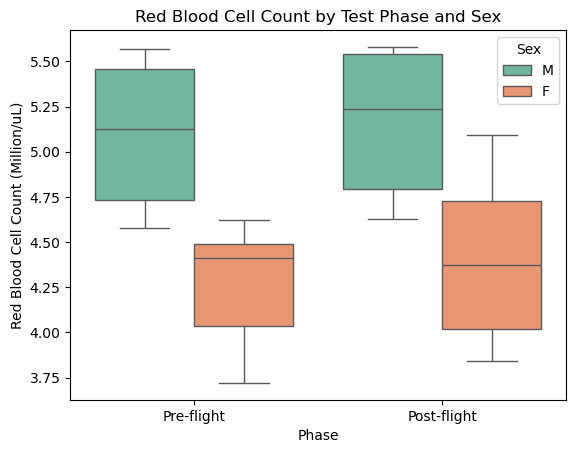

In [13]:
mean_wbc = df_wide.groupby(['PHASE', 'SEX'])['RED BLOOD CELL COUNT'].mean().reset_index()
sns.boxplot(data=df_wide, x='PHASE', y='RED BLOOD CELL COUNT', hue='SEX', palette='Set2')
plt.title('Red Blood Cell Count by Test Phase and Sex')
plt.xlabel('Phase')
plt.ylabel('Red Blood Cell Count (Million/uL)')
plt.legend(title='Sex')
plt.show()

In [14]:
model2 = ols("Q('WHITE BLOOD CELL COUNT') ~ SEX * PHASE", data=df_wide).fit()
anova_table = sm.stats.anova_lm(model2, typ=2)
print(anova_table)

              sum_sq    df         F    PR(>F)
SEX         2.892857   1.0  1.102945  0.304081
PHASE       6.134405   1.0  2.338834  0.139259
SEX:PHASE   0.262976   1.0  0.100264  0.754251
Residual   62.948333  24.0       NaN       NaN


White blood cell count does not significantly differ by sex or flight phase. There is also no interaction effect between sex and phase.

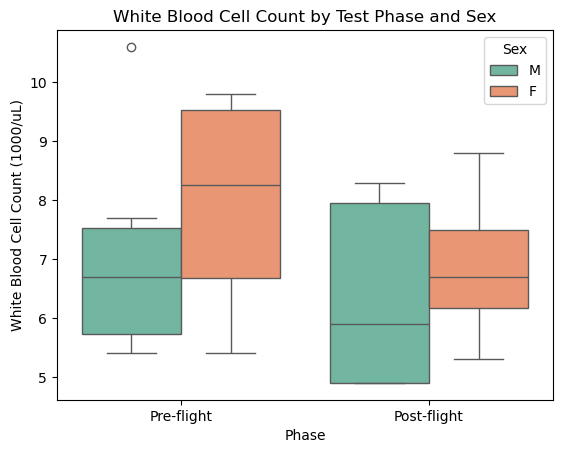

In [15]:
mean_wbc = df_wide.groupby(['PHASE', 'SEX'])['WHITE BLOOD CELL COUNT'].mean().reset_index()
sns.boxplot(data=df_wide, x='PHASE', y='WHITE BLOOD CELL COUNT', hue='SEX', palette='Set2')
plt.title('White Blood Cell Count by Test Phase and Sex')
plt.xlabel('Phase')
plt.ylabel('White Blood Cell Count (1000/uL)')
plt.legend(title='Sex')
plt.show()

In [16]:
model2 = ols('HEMOGLOBIN ~ SEX * PHASE', data=df_wide).fit()
anova_table = sm.stats.anova_lm(model2, typ=2)
print(anova_table)

              sum_sq    df          F    PR(>F)
SEX        47.320000   1.0  38.634594  0.000002
PHASE       0.013125   1.0   0.010716  0.918412
SEX:PHASE   0.001458   1.0   0.001191  0.972759
Residual   29.395417  24.0        NaN       NaN


Interpretation:
Sex is highly significant (p ≈ 0.000002). Hemoglobin levels differ significantly between male and female astronauts, which means sex has a strong influence on hemoglobin.
PHASE is not significant (p ≈ 0.918). There is no statistically significant difference in hemoglobin levels between the phases (pre-flight or post-flight). So, the timing of the test relative to the flight doesn’t seem to affect hemoglobin here.
The interaction between sex and phase is not significant (p ≈ 0.973), as the effect of phase on hemoglobin does not differ between males and females. In other words, how phase impacts hemoglobin is the same regardless of sex.

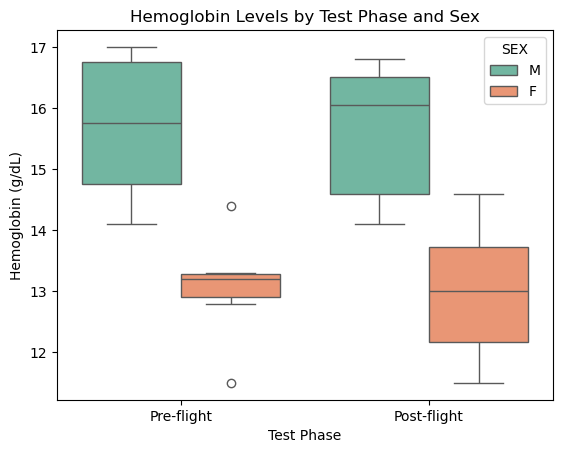

In [17]:
sns.boxplot(x='PHASE', y='HEMOGLOBIN', hue='SEX', data=df_wide, palette='Set2')
plt.title('Hemoglobin Levels by Test Phase and Sex')
plt.xlabel('Test Phase')
plt.ylabel('Hemoglobin (g/dL)')
plt.show()

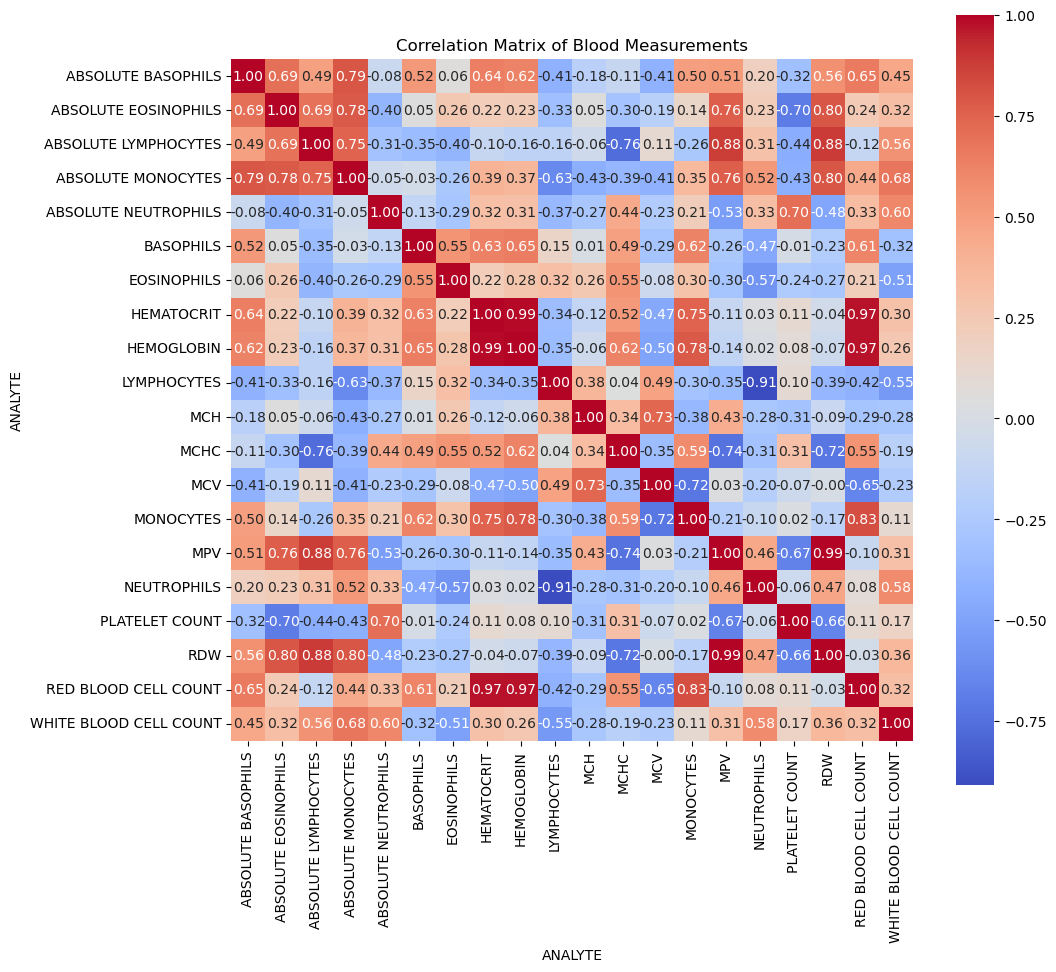

In [18]:
blood_cols = [
    'ABSOLUTE BASOPHILS', 'ABSOLUTE EOSINOPHILS', 'ABSOLUTE LYMPHOCYTES', 'ABSOLUTE MONOCYTES',
    'ABSOLUTE NEUTROPHILS', 'BASOPHILS', 'EOSINOPHILS', 'HEMATOCRIT', 'HEMOGLOBIN', 'LYMPHOCYTES',
    'MCH', 'MCHC', 'MCV', 'MONOCYTES', 'MPV', 'NEUTROPHILS', 'PLATELET COUNT', 'RDW',
    'RED BLOOD CELL COUNT', 'WHITE BLOOD CELL COUNT'
]
corr_matrix = df_wide[blood_cols].corr()
plt.figure(figsize=(11, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Blood Measurements')
plt.show()

In [19]:
import statsmodels.formula.api as smf
model = smf.ols('Q("RED BLOOD CELL COUNT") ~ SEX', data=df_wide).fit()
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     Q("RED BLOOD CELL COUNT")   R-squared:                       0.493
Model:                                   OLS   Adj. R-squared:                  0.473
Method:                        Least Squares   F-statistic:                     25.27
Date:                       Sun, 21 Sep 2025   Prob (F-statistic):           3.13e-05
Time:                               01:59:19   Log-Likelihood:                -13.892
No. Observations:                         28   AIC:                             31.78
Df Residuals:                             26   BIC:                             34.45
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

The regression model shows a significant effect of sex on red blood cell count (RBC). Specifically, males have on average about 0.78 units higher RBC count than females (coefficient = 0.78, p < 0.001). The intercept represents the average RBC count for females, estimated at about 4.35 units. This suggests that sex is an important factor influencing red blood cell levels in the astronaut data.

In [20]:
from statsmodels.formula.api import mixedlm
model_mixed = mixedlm('Q("RED BLOOD CELL COUNT") ~ SEX', data=df_wide, groups=df_wide['SUBJECT_ID'])
result = model_mixed.fit()
print(result.summary())

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q("RED BLOOD CELL COUNT")
No. Observations: 28      Method:             REML                     
No. Groups:       4       Scale:              0.0301                   
Min. group size:  7       Log-Likelihood:     1.9067                   
Max. group size:  7       Converged:          Yes                      
Mean group size:  7.0                                                  
---------------------------------------------------------------------------
              Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
---------------------------------------------------------------------------
Intercept     4.348        0.364     11.960     0.000      3.635      5.060
SEX[T.M]      0.784        0.514      1.524     0.127     -0.224      1.791
Group Var     0.260        1.586                                           



The model estimates the average red blood cell count (RBC) intercept at about 4.35 units. Males tend to have a higher RBC count than females by approximately 0.78 units; however, this difference is not statistically significant (p = 0.127), likely due to the small sample size and variability.

This accounts for repeated measurements within subjects (4 groups), which helps control for individual differences. The variance between subjects (i.e., Group Var) is relatively high, indicating that individual differences contribute notably to RBC variability. Overall, while sex shows a positive trend in RBC levels, it is not conclusively significant when accounting for repeated measures, suggesting more data may be needed for firm conclusions.

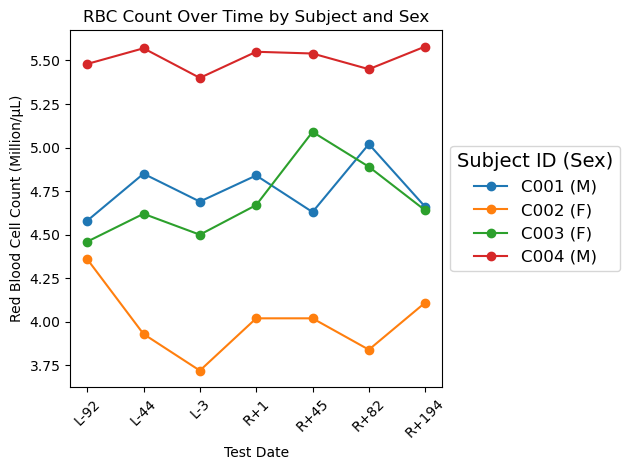

In [21]:
test_date_order = ['L-92', 'L-44', 'L-3', 'Launch', 'R+1', 'R+45', 'R+82', 'R+194']  
# convert TEST_DATE to categorical with specified order
df_wide['TEST_DATE'] = pd.Categorical(df_wide['TEST_DATE'], categories=test_date_order, ordered=True)
for subj in df_wide['SUBJECT_ID'].unique():
    subj_data = df_wide[df_wide['SUBJECT_ID'] == subj].sort_values('TEST_DATE')
    sex = subj_data['SEX'].iloc[0]
    label = f"{subj} ({sex})"
    plt.plot(subj_data['TEST_DATE'], subj_data['RED BLOOD CELL COUNT'], marker='o', label=label)

plt.xlabel('Test Date')
plt.ylabel('Red Blood Cell Count (Million/μL)')
plt.title('RBC Count Over Time by Subject and Sex')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title='Subject ID (Sex)', title_fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

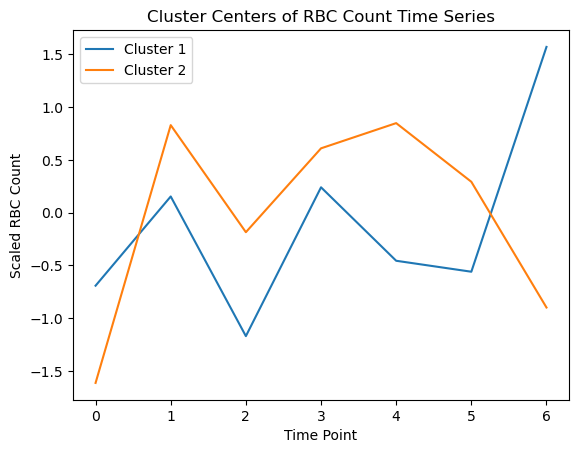

{'C001': 0, 'C002': 1, 'C003': 0, 'C004': 1}


In [23]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

#pivot so each subject is a row, time points are columns
data_pivot = df_wide.pivot(index='SUBJECT_ID', columns='TEST_DATE', values='RED BLOOD CELL COUNT')
data_pivot = data_pivot.interpolate(axis=1).bfill(axis=1).ffill(axis=1)
X = data_pivot.values
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X)
km = TimeSeriesKMeans(n_clusters=2, metric="dtw", random_state=0)
labels = km.fit_predict(X_scaled)
for i, center in enumerate(km.cluster_centers_):
    plt.plot(center.ravel(), label=f'Cluster {i+1}')
plt.legend()
plt.title('Cluster Centers of RBC Count Time Series')
plt.xlabel('Time Point')
plt.ylabel('Scaled RBC Count')
plt.show()
print(dict(zip(data_pivot.index, labels)))

Astronauts C001 and C003 are in the same cluster. The other two astronauts (C002 and C004) are in the other cluster.